In [1]:
import os
import sys

src_path = os.path.abspath('..')
print(src_path)
sys.path.append(src_path)

/home/zw12/MedLink/src


In [2]:
from utils import data_path, set_seed, create_directory

In [3]:
import csv
import json
from datetime import datetime
from collections import Counter, OrderedDict
import random
import pandas as pd
import numpy as np
from itertools import chain

In [4]:
set_seed(seed=42)

## read data

In [5]:
data = pd.read_csv(os.path.join(data_path, 'mimic3/processed/data.csv'))
data

,SUBJECT_ID,GENDER,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,ICD9_FULL_CODE,ICD9_3DIGIT_CODE,CCS_CODE,AGE
0,100,F,153952,2157-08-10,2157-08-18,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,4260 4411 4241 42731 99602,427 426 424 996 441,106 96 237 115 105,71.0
1,1000,M,143040,2144-01-19,2144-02-25,URGENT,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,5789 2773 4280 2851 0380 40391 78559 20300 5185,203 785 277 578 038 518 285 428 403,58 60 131 99 108 153 2 40 249,69.0
2,10000,M,187813,2186-08-10,2186-08-31,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,SHORT TERM HOSPITAL,Self Pay,SPAN,CATHOLIC,NaN,HISPANIC OR LATINO,5845 28521 2766 25000 5997 5723 5712 0414 5770...,456 577 285 289 286 599 250 403 571 303 584 99...,163 157 55 660 238 152 99 64 49 134 3 211 151 ...,49.0
3,10003,M,144039,2111-11-21,2111-12-02,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,82525 4582 2899 99811 4019 82523 8602 E8798 80708,860 458 998 825 289 E879 401 807,238 234 98 64 2616 230 231,41.0
4,10004,M,164713,2182-11-02,2182-11-19,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,E8889 78039 7837 51881 4619 5225 3484 2720 803...,272 780 518 522 348 599 461 401 783 803 507 25...,58 159 233 53 98 131 49 126 95 83 663 136 2603...,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50714,9999,M,117856,2134-12-26,2134-12-28,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicaid,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,79902 30301 2639 5711 2761 42741,799 427 571 303 263 276,55 660 52 107 244,43.0
50715,99991,M,151118,2184-12-24,2185-01-05,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,71947 5570 40291 5538 5644 V0254 E8788 4280 25...,553 719 V02 584 562 038 250 E878 557 789 788 4...,163 157 114 55 145 238 99 49 108 2616 204 2 15...,47.0
50716,99992,F,197084,2144-07-25,2144-07-28,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,5699 3004 53081 5772 2851 56881 4019 72992 579...,272 569 300 579 530 577 584 729 285 999 401 568,60 157 53 238 152 98 211 138 657 155,65.0
50717,99995,F,137810,2147-02-08,2147-02-11,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,E8798 4400 99812 4241 9961 V5861 4280 99811 25...,272 V10 998 285 250 V15 E879 414 428 424 996 V...,60 114 53 238 24 49 96 108 2616 237 115 257 66...,88.0


In [6]:
data.SUBJECT_ID = data.SUBJECT_ID.apply(lambda x: str(x))
data.HADM_ID = data.HADM_ID.apply(lambda x: str(x))

## split by admissions

In [7]:
num_admissions = data.groupby('SUBJECT_ID').HADM_ID.nunique().reset_index()
num_admissions = num_admissions.rename(columns={"HADM_ID": "NUM_ADM"})
num_admissions

,SUBJECT_ID,NUM_ADM
0,100,1
1,1000,1
2,10000,1
3,10003,1
4,10004,2
...,...,...
38543,9999,1
38544,99991,1
38545,99992,1
38546,99995,1


<Axes: xlabel='NUM_ADM'>

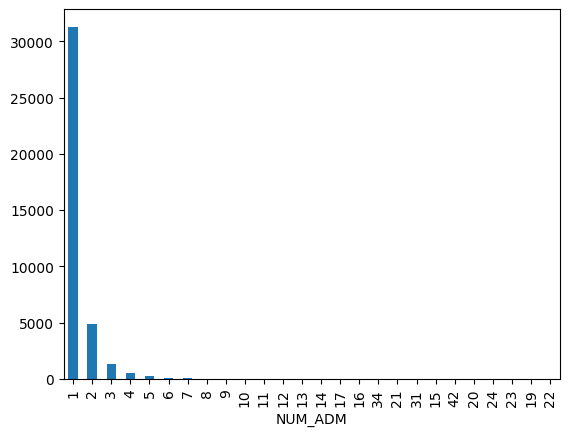

In [8]:
num_admissions.NUM_ADM.value_counts().plot.bar()

In [9]:
subj_ids_1adm = list(num_admissions[num_admissions.NUM_ADM == 1].SUBJECT_ID.unique())
len(subj_ids_1adm)

31281

In [10]:
data_1adm = data[data.SUBJECT_ID.isin(subj_ids_1adm)].reset_index(drop=True)
data_1adm.shape

(31281, 17)

In [11]:
subj_ids_madm = list(num_admissions[num_admissions.NUM_ADM >= 2].SUBJECT_ID.unique())
len(subj_ids_madm)

7267

In [12]:
data_madm = data[data.SUBJECT_ID.isin(subj_ids_madm)].reset_index(drop=True)
data_madm.shape

(19438, 17)

## tvt split

In [13]:
tvt_split = [0.7, 0.1, 0.2]
all_patients = list(data_madm.SUBJECT_ID.unique().tolist())
random.shuffle(all_patients)
s1 = tvt_split[0]
s2 = tvt_split[0] + tvt_split[1]
train_pids = all_patients[:int(len(all_patients) * s1)]
val_pids = all_patients[int(len(all_patients) * s1): int(len(all_patients) * s2)]
test_pids = all_patients[int(len(all_patients) * s2):]

In [14]:
print("# of train:", len(train_pids))
print("# of val:", len(val_pids))
print("# of test:", len(test_pids))

# of train: 5086
# of val: 727
# of test: 1454


## pretrain

In [15]:
data_madm_train = data_madm[data_madm.SUBJECT_ID.isin(train_pids)]
data_madm_train.shape

(13704, 17)

In [16]:
data_pretrain = pd.concat([data_1adm, data_madm_train])
data_pretrain.shape

(44985, 17)

## convert to retrieval task data format

qrels

In [17]:
pid_to_vids = data_madm.groupby('SUBJECT_ID').HADM_ID.agg(list)
pid_to_vids

SUBJECT_ID
10004                    [164713, 161106]
1004                     [127794, 177186]
10059                    [142582, 122098]
1006     [147743, 189081, 199286, 108462]
10071                    [150259, 114392]
                       ...               
9984                     [194393, 127830]
99883                    [150755, 198523]
99897                    [162913, 181057]
99923                    [164914, 192053]
99982            [151454, 112748, 183791]
Name: HADM_ID, Length: 7267, dtype: object

In [18]:
# in: ['1', '2', '3']
# out: {'3': {'2': 1}}
def generate_qrel(lst):
    q = lst[-1]
    rel = lst[-2]
    qrel = {q: {rel: 1}}
    return qrel


generate_qrel(['1', '2', '3'])

{'3': {'2': 1}}

In [19]:
# in: [{'3': {'2': 1}}, {'6': {'5': 1}}]
# out: {'3': {2': 1}, '6': {'5': 1}}
def merge_dict(lst):
    ret = {}
    for dct in lst:
        for k, v in dct.items():
            ret[k] = v
    return ret


merge_dict([{'3': {'2': 1}}, {'6': {'5': 1}}])

{'3': {'2': 1}, '6': {'5': 1}}

In [20]:
train_qrels = merge_dict([generate_qrel(pid_to_vids[pid]) for pid in train_pids])
val_qrels = merge_dict([generate_qrel(pid_to_vids[pid]) for pid in val_pids])
test_qrels = merge_dict([generate_qrel(pid_to_vids[pid]) for pid in test_pids])

In [21]:
print("# of train:", len(train_qrels))
print("# of val:", len(val_qrels))
print("# of test:", len(test_qrels))

# of train: 5086
# of val: 727
# of test: 1454


corpus & queries

In [22]:
vid_to_codes = data_madm[['HADM_ID', 'ICD9_FULL_CODE', 'ICD9_3DIGIT_CODE', 'CCS_CODE']].set_index('HADM_ID').to_dict()

In [23]:
def generate_corpus_and_queries(qrels, vid_to_codes):
    queries = {'ICD9_FULL_CODE': {}, 'ICD9_3DIGIT_CODE': {}, 'CCS_CODE': {}}
    corpus = {'ICD9_FULL_CODE': {}, 'ICD9_3DIGIT_CODE': {}, 'CCS_CODE': {}}
    for q_vid, corpus_dict in qrels.items():
        for k in queries:
            queries[k][q_vid] = vid_to_codes[k][q_vid]
        for c_vid in corpus_dict.keys():
            for k in corpus:
                corpus[k][c_vid] = vid_to_codes[k][c_vid]
    return queries, corpus

In [24]:
train_queries, train_corpus = generate_corpus_and_queries(train_qrels, vid_to_codes)
val_queries, val_corpus = generate_corpus_and_queries(val_qrels, vid_to_codes)
test_queries, test_corpus = generate_corpus_and_queries(test_qrels, vid_to_codes)

In [25]:
queries = {'ICD9_FULL_CODE': {}, 'ICD9_3DIGIT_CODE': {}, 'CCS_CODE': {}}
corpus = {'ICD9_FULL_CODE': {}, 'ICD9_3DIGIT_CODE': {}, 'CCS_CODE': {}}
for code in ['ICD9_FULL_CODE', 'ICD9_3DIGIT_CODE', 'CCS_CODE']:
    queries[code] = merge_dict([train_queries[code], val_queries[code], test_queries[code]])
    corpus[code] = merge_dict([train_corpus[code], val_corpus[code], test_corpus[code]])

## save

In [26]:
data_pretrain.to_csv(os.path.join(data_path, 'mimic3/processed/data_pretrain.csv'), index=False)
data_madm.to_csv(os.path.join(data_path, 'mimic3/processed/data_madm.csv'), index=False)

In [27]:
for code in ['ICD9_FULL_CODE', 'ICD9_3DIGIT_CODE', 'CCS_CODE']:
    create_directory(os.path.join(data_path, f'mimic3/processed/mimic3_{code}'))

qrels

In [28]:
def save_qrels(qrels, split, path):
    create_directory(os.path.join(path, 'qrels'))
    with open(os.path.join(path, f'qrels/{split}.tsv'), 'wt') as out_file:
        tsv_writer = csv.writer(out_file, delimiter='\t')
        tsv_writer.writerow(['query-id', 'corpus-id', 'score'])
        qids = list(qrels.keys())
        qids = sorted(qids)
        for qid in qids:
            for cid, score in qrels[qid].items():
                tsv_writer.writerow([qid, cid, score])

In [29]:
for code in ['ICD9_FULL_CODE', 'ICD9_3DIGIT_CODE', 'CCS_CODE']:
    save_qrels(train_qrels, 'train', os.path.join(data_path, f'mimic3/processed/mimic3_{code}'))
    save_qrels(val_qrels, 'val', os.path.join(data_path, f'mimic3/processed/mimic3_{code}'))
    save_qrels(test_qrels, 'test', os.path.join(data_path, f'mimic3/processed/mimic3_{code}'))

corpus and queries

In [30]:
def save_corpus(corpus, filename):
    ids = corpus.keys()
    ids = sorted(ids)
    with open(filename, 'w') as outfile:
        for _id in ids:
            entry = {}
            entry['_id'] = _id
            entry['title'] = ''
            entry['text'] = corpus[_id]
            json.dump(entry, outfile)
            outfile.write('\n')

In [31]:
def save_queries(queries, filename):
    ids = queries.keys()
    ids = sorted(ids)
    with open(filename, 'w') as outfile:
        for _id in ids:
            entry = {}
            entry['_id'] = _id
            entry['text'] = queries[_id]
            json.dump(entry, outfile)
            outfile.write('\n')

In [32]:
for code in ['ICD9_FULL_CODE', 'ICD9_3DIGIT_CODE', 'CCS_CODE']:
    save_corpus(corpus[code], os.path.join(data_path, f'mimic3/processed/mimic3_{code}/corpus.jsonl'))
    save_queries(queries[code], os.path.join(data_path, f'mimic3/processed/mimic3_{code}/queries.jsonl'))

pids

In [33]:
def to_txt(data, filename):
    with open(filename, 'w') as f:
        for item in data:
            try:
                f.write("%s\n" % item)
            except TypeError:
                f.write("%s\n" % ' '.join([str(i) for i in item]))

In [34]:
to_txt(train_pids, os.path.join(data_path, 'mimic3/processed/train_pids.txt'))
to_txt(val_pids, os.path.join(data_path, 'mimic3/processed/val_pids.txt'))
to_txt(test_pids, os.path.join(data_path, 'mimic3/processed/test_pids.txt'))